In [1]:
import operator
import numpy as np
import matplotlib.pyplot as plt


Number game rules:
- program takes number(numbers) and prints selected hypothesis using apropriate method
- numbers are in range [1-500] (inclusive)
- hypothesis space : odd numbers, even numbers, arithmetic sequences ([2,4,6,8,10,12,...], [3,6,9,12,15,...], ..., [40,80,120,160,...], ...)

### Implement a simple number game based only on the likelihood:
- the program takes a number or an array of numbers 
- print likelihood of each possible concept (satisfied by given number/numbers) sorted by likelihood

In [2]:
def clean_hipothesis_space(data, concepts):
    h_space = concepts.copy()

    for h_name, callback in concepts.items():
        if h_name == 'sequence':
            continue
        
        for d in data:
            if not callback(d):
                del h_space[h_name]
                break
                
    if 'sequence' in concepts and not concepts['sequence'](data):
        del h_space['sequence']
                
    return h_space

In [3]:
def generate_extensions(h_space, data):
    h_extensions = {h_name: [i for i in range(1, 501) if callback(i)]
                        for h_name, callback in h_space.items() if h_name != 'sequence'}
    
    if h_space.get('sequence', None) and len(data) > 1:
        step = data[1] - data[0]
        h_extensions['sequence'] = np.arange(1, 501, step)
        
    return h_extensions

In [17]:
def get_likelihood_for_given_concepts_and_data(data, h_space, l_sorted=False):
    h_space = clean_hipothesis_space(data, h_space)

    h_extensions = generate_extensions(h_space, data)
    
    likelihoods = {h_name: (1 / len(extension)) ** len(data) 
                            for h_name, extension in h_extensions.items()}
    
    if l_sorted:
        return sorted(likelihoods.items(), key=lambda x: x[1], reverse=True)
    
    return likelihoods

In [5]:
data1 = [2, 256, 16, 32, 64]
data2 = [2, 6, 8, 10]
data3 = [1, 13, 5, 7, 57]
data4 = [10, 20, 30, 40]

h_space = {
    'power of 2': lambda n: n != 0 and ((n & (n - 1)) == 0),
    'is even': lambda n: n % 2 == 0,
    'is odd': lambda n: n % 2 != 0,
    'sequence': lambda data: not np.any(np.diff(data, 2))
}

for d in [data1, data2, data3, data4]:
    print(get_likelihood_for_given_concepts_and_data(d, h_space, True))

{'power of 2': 1.6935087808430282e-05, 'is even': 1.024e-12}
[('power of 2', 1.6935087808430282e-05), ('is even', 1.024e-12)]
{'is even': 2.5600000000000005e-10}
[('is even', 2.5600000000000005e-10)]
{'is odd': 1.024e-12}
[('is odd', 1.024e-12)]
{'is even': 2.5600000000000005e-10, 'sequence': 1.6e-07}
[('sequence', 1.6e-07), ('is even', 2.5600000000000005e-10)]


### Implement a simple number game based only on the posterior:
- the program takes an array of numbers and representation of prior probabilities(in any form, ex. lambda function, array etc.)
- print posterior of each possible concept (satisfied by given number) sorted by posterior

In [6]:
def get_posteriors(data, h_space, priors, l_sorted=False):
    likelihoods = get_likelihood_for_given_concepts_and_data(data, h_space)
    
    norm = np.sum([priors[h_name] * likelihood for h_name, likelihood in likelihoods.items()])
        
    posteriors = {h_name: (priors[h_name] * likelihood) / norm
                    for h_name, likelihood in likelihoods.items()}
    
    if l_sorted:
        return sorted(posteriors.items(), key=lambda x: x[1], reverse=True)
    
    return posteriors

In [7]:
p2_prob = 0.0000001

priors = {
          'power of 2': p2_prob,
          'is even': 1 - p2_prob, 
         }

get_posteriors(data1, h_space, priors, True)

{'power of 2': 1.6935087808430282e-05, 'is even': 1.024e-12}


[('power of 2', 0.62318431373448591), ('is even', 0.37681568626551415)]

### Implement a number game:
- we can specify concepts manually using lambda functions
    - lambda function says if given number is in given concept or not
- the program accepts input numbers in an array
- print sorted likelihood and posterior of hypothesis satisfying given numbers
- use the MAP to select a correct hypothesis

In [23]:
def get_map_estimate(data, h_space, priors, estimates=False, verbose=False):
    likelihoods = get_likelihood_for_given_concepts_and_data(data, h_space)
    posteriors = get_posteriors(data1, h_space, priors)
    
    if verbose:
        print("Likelihoods: ", sorted(likelihoods.items(), key=lambda x: x[1], reverse=True))
        print("Posteriors: ", sorted(posteriors.items(), key=lambda x: x[1], reverse=True))

    map_est = { h_name: np.log(l) + np.log(p)
                        for (h_name, l), (_, p) in zip(likelihoods.items(), posteriors.items())}
    
    if estimates:
        return map_est
    
    return max(map_est.items(), key=operator.itemgetter(1))[0]
    
get_map_estimate(data1, h_space, priors, False, True)

Likelihoods:  [('power of 2', 1.6935087808430282e-05), ('is even', 1.024e-12)]
Posteriors:  [('power of 2', 0.99999885114397591), ('is even', 1.1488560241283198e-06)]


'power of 2'

### Check if MAP converges to MLE:
- create chart:
    - X axis - number of examples (up to whole concept)
    - Y axis - MAP and MLE
- test for 5 different hypothesis 
- assume some prior probabilities

In [9]:
def get_maximum_likelihood_estimate(data, h_space, estimates=False):
    likelihoods = get_likelihood_for_given_concepts_and_data(data, h_space)
    
    mle = { h_name: np.log(l) for h_name, l in likelihoods.items() }
    
    if estimates:
        return mle
    
    return max(mle.items(), key=operator.itemgetter(1))[0]
    
get_maximum_likelihood_estimate(data1, h_space, True)

{'power of 2': 1.6935087808430282e-05, 'is even': 1.024e-12}


{'is even': -27.607304589311234, 'power of 2': -10.986122886681096}

In [10]:
get_map_estimate(data1, h_space, priors, True)

{'power of 2': 1.6935087808430282e-05, 'is even': 1.024e-12}
{'power of 2': 1.6935087808430282e-05, 'is even': 1.024e-12}


{'is even': -28.583303696241344, 'power of 2': -11.459035841939386}

In [24]:
h_space = {
    'power of 2': lambda n: n != 0 and ((n & (n - 1)) == 0),
    'power of 2 + 7': lambda n: n != 0 and (((n - 7) & (n - 8)) == 0),
    'is even': lambda n: n % 2 == 0,
    'is odd': lambda n: n % 2 != 0,
    'sequence': lambda data: not np.any(np.diff(data, 2))
}

extensions = generate_extensions(h_space, [1, 15])

priors = {
          'power of 2': 0.01,
          'power of 2 + 7': 0.3,
          'is even': 0.19,
          'is odd': 0.2,
          'sequence': 0.3, 
         }

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


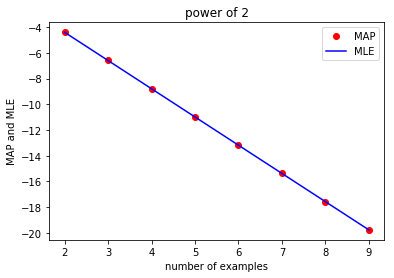

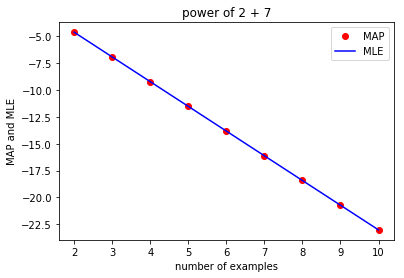

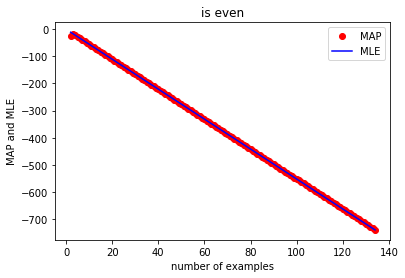

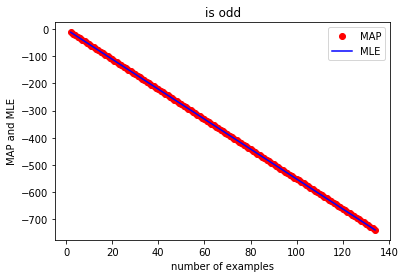

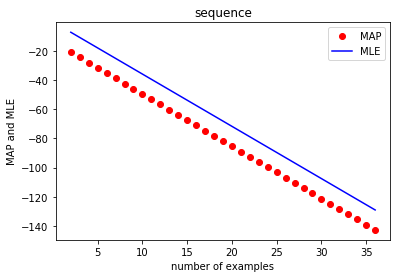

In [25]:
for h_name in h_space.keys():
    maps = []
    mles = []
    lengths = []
    
    data_range = range(2, len(extensions[h_name]) + 1)
    
    for i in data_range:
        data = extensions[h_name][:i]

        maps.append(get_map_estimate(data, h_space, priors, True)[h_name])
        mles.append(get_maximum_likelihood_estimate(data, h_space, True)[h_name])
        
        lengths.append(len(data))
                        
    fig, ax = plt.subplots()
        
    line_up, = ax.plot(lengths, maps, 'ro', label="MAP")
    line_down, = ax.plot(lengths, mles, 'blue', label="MLE")
    
    ax.set_title(h_name)
    ax.set_xlabel("number of examples")
    ax.set_ylabel("MAP and MLE")
    
    plt.legend(handles=[line_up, line_down])
    
        